In [ ]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 

import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # or another metric
# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [18]:
# Import Data
df = pd.read_csv('Traffic_Volume (1).csv')

In [51]:
#converting data structure to proper format
df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month_name()
df['weekday'] = df['date_time'].dt.day_name()  
df['hour'] =df['date_time'].dt.hour

df_clean = df.drop(columns = ['date_time'])
df_clean.to_csv('traffic_volume_clean.csv', index=False)

In [25]:
# Select input and output features
X = df_clean.drop(columns = ['traffic_volume'])
y = df_clean['traffic_volume']

In [26]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,hour,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,...,month_November,month_October,month_September,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,288.28,0.0,0.0,40,9,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,289.36,0.0,0.0,75,10,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,289.58,0.0,0.0,90,11,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
3,290.13,0.0,0.0,90,12,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,291.14,0.0,0.0,75,13,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


In [27]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [28]:
# Define model
reg = xgb.XGBRegressor(random_state = 42)

In [29]:
# Fit the model
start = time.time()            # Start Time
reg.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 0.2919611930847168s


In [30]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 426.26


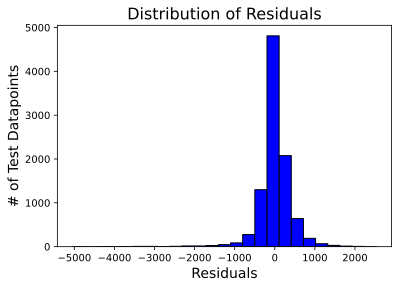

In [35]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'blue', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('residual_plot.svg')

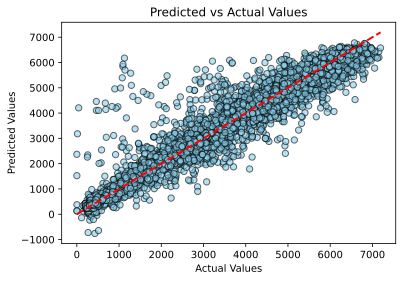

In [36]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'skyblue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig('pred_vs_actual.svg')

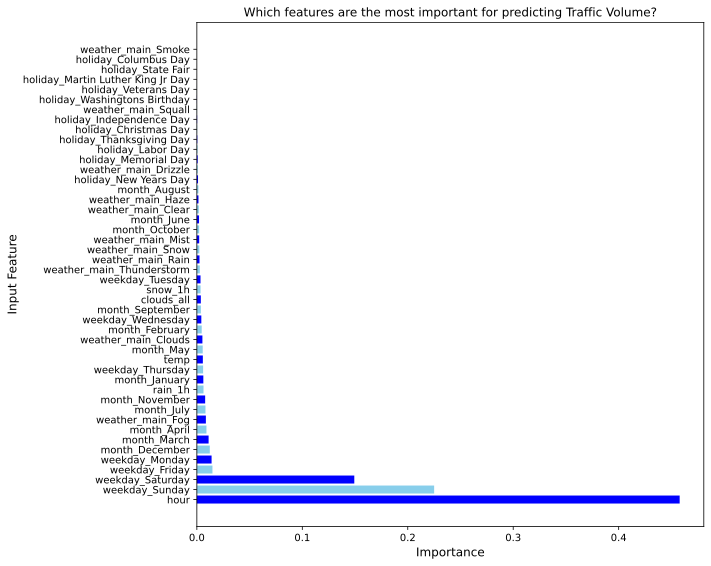

In [39]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['blue', 'skyblue'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting Traffic Volume?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();
plt.savefig('feature_imp.svg')

In [40]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1, # Number of cores to use: -1 means all cores
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.05 # 0.1 For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 6.939139366149902s


In [42]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2685.550049,1876.51,3483.49
34004,5251,5228.100098,4408.07,6017.45
46086,2224,1909.339966,1263.83,2875.44
42579,2928,2781.399902,2053.21,3682.82
23709,910,593.780029,-219.89,1387.32


In [43]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 95.86%


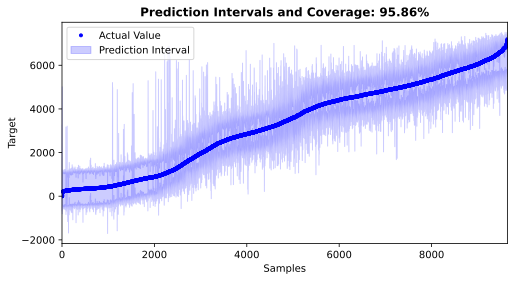

In [48]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with blue dots
plt.plot(sorted_predictions["Actual Value"], 'bo', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent blue color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="blue", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);
plt.savefig('coverage.svg')

In [49]:
# Creating the file where we want to write the model
reg_pickle = open('traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()